# Actividad 3.1
## Detección de Peatones con SVM

---

### Integrantes del Equipo 23:
* Carlos Pano Hernández - A01066264 [Campus Estado de México]
* Marie Kate Palau - A01705711 [Campus Monterrey]
* Edson Ulises Rodríguez Dávalos - A01796057 [Campus CdMx]
* Yohanna Ceballos Salomón - A01795115 [Campus Monterrey]

---

### Escuela de Ingeniería y Ciencias, Tecnológico de Monterrey
**Navegación autónoma (MR4010 - Gpo 10)**

---

#### Profesor Titular:
Dr. David Antonio Torres

#### Profesor Asistente:
Mtra. María Mylen Treviño Elizondo

---

**Viernes 16 de mayo del 2025**

In [1]:
# Importing main libraries
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import glob
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## 2. Loading Image File Paths

The following Python code block is responsible for locating and listing the image files that will be used for training and testing our pedestrian detection model.

In [2]:
people = glob.glob("data/people/*.jpg")
non_people = glob.glob("data/non-people/*.jpg")

print(f"Number of pedestrian images: {len(people)}")
print(f"Number of non-pedestrian images: {len(non_people)}")

Number of pedestrian images: 4246
Number of non-pedestrian images: 4006


## 3. Image Preprocessing: Resizing to a Uniform Dimension

Before we can extract features using Histogram of Oriented Gradients (HOG), it's essential that all our images have the same dimensions. Original images in a dataset often vary in size and aspect ratio.

In [3]:
# Function to resize images to 64x64
def resize_image(image_path):
    img = mpimg.imread(image_path)
    return cv2.resize(img, (64, 64))

# Resize all people images to 64x64
print("Resizing pedestrian images to 64x64...")
for i, image_path in enumerate(people):
    resized = resize_image(image_path)
    cv2.imwrite(image_path, resized)
    
# Resize all non-people images to 64x64 
print("Resizing non-pedestrian images to 64x64...")
for i, image_path in enumerate(non_people):
    resized = resize_image(image_path)
    cv2.imwrite(image_path, resized)

print("All images have been resized to 64x64")

Resizing pedestrian images to 64x64...
Resizing non-pedestrian images to 64x64...
All images have been resized to 64x64


## 4. HOG Feature Extraction and Dataset Preparation

With our images standardized to a uniform size (64x64 pixels), we can now proceed to extract Histogram of Oriented Gradients (HOG) features. This entire process transforms our visual image data into a structured numerical dataset (`X` features and `y` labels), which is the required input format for training our classification model.

In [4]:
people_hog_accum = []
non_people_hog_accum = []

# Process pedestrian images
for i in people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    people_hog_feature,people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    people_hog_accum.append(people_hog_feature)

# Process non-pedestrian images    
for i in non_people:
    img_color = mpimg.imread(i)
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features and visualization
    non_people_hog_feature,non_people_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    non_people_hog_accum.append(non_people_hog_feature)
    
# Check dimensions of HOG features before stacking -> IT FAILS IF NOT THE SAME.
people_feature_sizes = [f.shape[0] for f in people_hog_accum]
non_people_feature_sizes = [f.shape[0] for f in non_people_hog_accum]
print("Pedestrian HOG feature sizes:", people_feature_sizes)
print("Non-pedestrian HOG feature sizes:", non_people_feature_sizes)
print("\n")

# Stack all HOG features vertically into single array and convert to float64
X_people = np.vstack(people_hog_accum).astype(np.float64)
X_non_people = np.vstack(non_people_hog_accum).astype(np.float64)

# Create label arrays (1 = pedestrian, 0 = non-pedestrian)
y_people = np.ones(len(X_people))
y_non_people = np.zeros(len(X_non_people))

print(f"Shape of pedestrian HOG features array (X_people): {X_people.shape}")
print(f"Shape of pedestrian labels array (y_people): {y_people.shape}")
print("\n")
print(f"Shape of non-pedestrian HOG features array (X_non_people): {X_non_people.shape}")
print(f"Shape of non-pedestrian labels array (y_non_people): {y_non_people.shape}")

Pedestrian HOG feature sizes: [396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396,

## 5. Data Combination, Splitting, and SVM Model Training

Having extracted HOG features and created corresponding labels for both pedestrian (`_people`) and non-pedestrian (`_non_people`) images, we now need to prepare this data for training our Support Vector Machine (SVM) classifier.

After this code block executes, we will have a trained SVM model (`svc_model`) ready to make predictions.

In [5]:
# Combine pedestrian and non-pedestrian data
X = np.vstack((X_people,X_non_people))
y = np.hstack((y_people,y_non_people))

print(f"Shape of combined HOG features array (X): {X.shape}")
print(f"Shape of combined labels array (y): {y.shape}")
print("\n")

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

print(f"Shape of training features (X_train): {X_train.shape}")
print(f"Shape of training labels (y_train): {y_train.shape}")
print(f"Shape of test features (X_test): {X_test.shape}") 
print(f"Shape of test labels (y_test): {y_test.shape}")

# Train SVM classifier
svc_model = SVC()
svc_model.fit(X_train,y_train)

Shape of combined HOG features array (X): (8252, 396)
Shape of combined labels array (y): (8252,)


Shape of training features (X_train): (6601, 396)
Shape of training labels (y_train): (6601,)
Shape of test features (X_test): (1651, 396)
Shape of test labels (y_test): (1651,)


SVC()

## 6. Model Evaluation: Predictions and Confusion Matrix

Now that our Support Vector Machine (SVM) model (`svc_model`) has been trained, the next crucial step is to evaluate its performance on the unseen test data (`X_test`, `y_test`). This will give us an idea of how well the model generalizes to new instances, which is a key indicator of its real-world utility.

In [10]:
# Save the trained model
import joblib
joblib.dump(svc_model, 'pedestrian_detector.pkl')

# Test on new data
test_path = '/Users/charliepano/Desktop/navegacion-autonoma-equipo23/Actividad3/data_test_webots'
test_images = []
for img_file in os.listdir(test_path):
    if img_file.endswith('.png') or img_file.endswith('.jpg'):
        img_path = os.path.join(test_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            # Resize to match training data dimensions (396 HOG features)
            # For 396 HOG features with given parameters, input image should be around (36,36)
            img_resized = cv2.resize(img, (36, 36))
            img_hog = hog(img_resized, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), channel_axis=2)
            test_images.append(img_hog)

# Convert to numpy array and predict
X_new = np.array(test_images)
y_new_pred = svc_model.predict(X_new)

# Print results
print("Predictions for test images:")
for i, pred in enumerate(y_new_pred):
    print(f"Image {i+1}: {'Pedestrian' if pred == 1 else 'Non-pedestrian'}")

# Original confusion matrix visualization
y_predict = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ValueError: X has 3780 features, but SVC is expecting 396 features as input.

## 7. Detailed Classification Metrics Report

While the confusion matrix gives us a raw count of correct and incorrect predictions, a classification report provides a more nuanced view of the model's performance by calculating several key metrics for each class (pedestrian and non-pedestrian). This report helps in understanding the precision, recall, and F1-score, which are often more informative than plain accuracy, especially if the classes are imbalanced.

In [7]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       802
         1.0       0.98      0.96      0.97       849

    accuracy                           0.97      1651
   macro avg       0.97      0.97      0.97      1651
weighted avg       0.97      0.97      0.97      1651



## 8. Hyperparameter Tuning with GridSearchCV

Previously, we trained an SVM classifier using its default hyperparameter settings. However, the performance of machine learning models, including SVMs, can be significantly influenced by their hyperparameters. To find the optimal settings for our specific dataset and problem, we will perform hyperparameter tuning.

In [8]:
# Define hyperparameter search space
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

# Perform grid search
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.942 total time=   1.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   1.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.946 total time=   1.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.945 total time=   1.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.951 total time=   1.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.947 total time=   1.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.946 total time=   1.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.953 total time=   1.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.952 total time=   1.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.955 total time=   1.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.917 total time=   2.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

## 9. Analyzing GridSearchCV Results and Evaluating the Optimized Model

The `GridSearchCV` process has now completed its search for the best hyperparameters for our SVM model based on cross-validation performance on the training data.

Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best estimator: SVC(C=1, gamma=1)


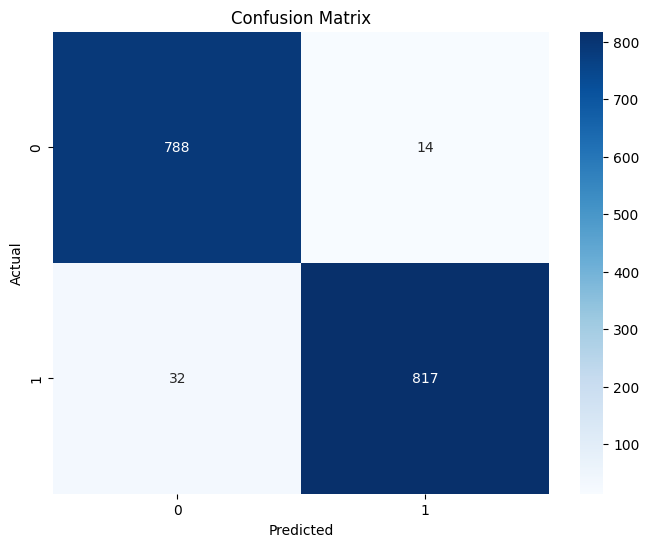

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       802
         1.0       0.98      0.96      0.97       849

    accuracy                           0.97      1651
   macro avg       0.97      0.97      0.97      1651
weighted avg       0.97      0.97      0.97      1651



In [9]:
# Print the best hyperparameters found during grid search
print("Best parameters:", grid.best_params_)

# Print the best model with optimal parameters
print("Best estimator:", grid.best_estimator_)

# Make predictions using the optimized model
grid_predictions = grid.predict(X_test)

# Create and plot confusion matrix
cm = confusion_matrix(y_test,grid_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print detailed classification metrics
print("Classification Report:")
print(classification_report(y_test,grid_predictions))